# Predicción de Precios de Autos Usados con Mejoras

Este notebook implementa un modelo de predicción de precios para autos usados con las siguientes mejoras:

1. **Manejo robusto de valores faltantes**: El modelo puede hacer predicciones incluso cuando faltan algunas variables de entrada.

2. **Registro de métricas**: Se guardan las métricas del modelo (RMSE, MAE, R²) en los logs para cada predicción.

3. **Mecanismo de fallback**: Si el modelo no puede hacer una predicción, se utiliza una estimación basada en vehículos comparables.

Estas mejoras hacen que la aplicación sea más robusta y proporciona mejor información sobre el rendimiento del modelo.

In [26]:
#cargar librerias
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split

from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

In [27]:
#Cargando la data
data = pd.read_csv('used_cars.csv')
data.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,Ford,Utility Police Interceptor Base,2013,"51,000 mi.",E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6-Speed A/T,Black,Black,At least 1 accident or damage reported,Yes,"$10,300"
1,Hyundai,Palisade SEL,2021,"34,742 mi.",Gasoline,3.8L V6 24V GDI DOHC,8-Speed Automatic,Moonlight Cloud,Gray,At least 1 accident or damage reported,Yes,"$38,005"
2,Lexus,RX 350 RX 350,2022,"22,372 mi.",Gasoline,3.5 Liter DOHC,Automatic,Blue,Black,None reported,NaN,"$54,598"
3,INFINITI,Q50 Hybrid Sport,2015,"88,900 mi.",Hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,7-Speed A/T,Black,Black,None reported,Yes,"$15,500"
4,Audi,Q3 45 S line Premium Plus,2021,"9,835 mi.",Gasoline,2.0L I4 16V GDI DOHC Turbo,8-Speed Automatic,Glacier White Metallic,Black,None reported,NaN,"$34,999"


In [28]:
# Limpieza de datos
# Convertir precio y millaje a valores numéricos eliminando caracteres no numéricos
import re

# Función para limpiar y convertir a números
def clean_numeric(x):
    if isinstance(x, str):
        return int(''.join(re.findall(r'\d+', x)))
    return x

# Aplicar la limpieza a las columnas price y milage
data['price'] = data['price'].apply(clean_numeric)
data['milage'] = data['milage'].apply(clean_numeric)

# Dividir en características (X) y variable objetivo (y)
y = data['price']
X = data.drop('price', axis=1)

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train size:", X_train.shape, y_train.shape)
print("Test size:", X_test.shape, y_test.shape)

Train size: (3207, 11) (3207,)
Test size: (802, 11) (802,)


In [29]:
# Preprocesamiento y creación de características adicionales
# Basado en las técnicas del notebook mse-mae-autogluon

# 1. Extracción de características relacionadas con la edad del vehículo
def extract_age_features(df):
    current_year = 2025  # Año actual
    
    # Edad del vehículo
    df['Vehicle_Age'] = current_year - df['model_year']
    
    # Millaje por año
    df['Mileage_per_Year'] = df['milage'] / df['Vehicle_Age'].replace(0, 1)  # Evitar división por cero
    
    # Promedio de millaje por edad del vehículo
    df['milage_with_age'] = df.groupby('Vehicle_Age')['milage'].transform('mean')
    
    # Promedio de millaje por año según la edad del vehículo
    df['Mileage_per_Year_with_age'] = df.groupby('Vehicle_Age')['Mileage_per_Year'].transform('mean')
    
    return df

# 2. Extracción de otras características útiles
def extract_other_features(df):
    # Marcas de lujo
    luxury_brands = ['Mercedes-Benz', 'BMW', 'Audi', 'Porsche', 'Land', 
                    'Lexus', 'Jaguar', 'Bentley', 'Maserati', 'Lamborghini', 
                    'Rolls-Royce', 'Ferrari', 'McLaren', 'Aston', 'Maybach']
    
    df['Is_Luxury_Brand'] = df['brand'].apply(lambda x: 1 if x in luxury_brands else 0)
    
    return df

# 3. Manejo de variables categóricas
def preprocess_categorical(df):
    # Umbral para valores raros
    threshold = 10
    
    # Columnas categóricas
    cat_cols = ['brand', 'model', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title']
    
    # Columnas a simplificar (reemplazar valores raros con "noise")
    cols_to_simplify = ['model', 'engine', 'transmission', 'ext_col', 'int_col']
    
    # Reemplazar valores raros con "noise"
    for col in cols_to_simplify:
        value_counts = df[col].value_counts(dropna=False)
        mask = df[col].map(value_counts) < threshold
        df.loc[mask, col] = "noise"
    
    # Rellenar valores nulos y convertir a categoría
    for col in cat_cols:
        df[col] = df[col].fillna('missing')
        df[col] = df[col].astype('category')
    
    return df

# Aplicar transformaciones a los conjuntos de entrenamiento y prueba
X_train = extract_age_features(X_train.copy())
X_test = extract_age_features(X_test.copy())

X_train = extract_other_features(X_train)
X_test = extract_other_features(X_test)

X_train = preprocess_categorical(X_train)
X_test = preprocess_categorical(X_test)

# Mostrar las nuevas características
print("Características después del preprocesamiento:")
print(X_train.columns.tolist())
print("\nTipos de datos:")
print(X_train.dtypes)

Características después del preprocesamiento:
['brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title', 'Vehicle_Age', 'Mileage_per_Year', 'milage_with_age', 'Mileage_per_Year_with_age', 'Is_Luxury_Brand']

Tipos de datos:
brand                        category
model                        category
model_year                      int64
milage                          int64
fuel_type                    category
engine                       category
transmission                 category
ext_col                      category
int_col                      category
accident                     category
clean_title                  category
Vehicle_Age                     int64
Mileage_per_Year              float64
milage_with_age               float64
Mileage_per_Year_with_age     float64
Is_Luxury_Brand                 int64
dtype: object


In [12]:
# Instalación de las librerías necesarias si no están ya instaladas
# Descomenta las siguientes líneas si necesitas instalar alguna librería
# !pip install -U autogluon lightgbm xgboost catboost

In [30]:
# Importar librerías de scikit-learn para modelos de regresión
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score, KFold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Función para evaluar modelos con validación cruzada
def evaluate_model(model, X, y, cv=5):
    # Calcular métricas usando validación cruzada
    mse_scores = -cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error')
    mae_scores = -cross_val_score(model, X, y, cv=cv, scoring='neg_mean_absolute_error')
    r2_scores = cross_val_score(model, X, y, cv=cv, scoring='r2')
    
    # Calcular RMSE
    rmse_scores = np.sqrt(mse_scores)
    
    # Imprimir resultados
    print(f"RMSE: {np.mean(rmse_scores):.2f} (±{np.std(rmse_scores):.2f})")
    print(f"MAE: {np.mean(mae_scores):.2f} (±{np.std(mae_scores):.2f})")
    print(f"R²: {np.mean(r2_scores):.2f} (±{np.std(r2_scores):.2f})")
    
    return np.mean(rmse_scores), np.mean(mae_scores), np.mean(r2_scores)

# Función para obtener predicciones out-of-fold
def get_oof_predictions(model, X, y, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    oof_predictions = np.zeros(len(X))
    trained_models = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        print(f"Entrenando fold {fold + 1}/{n_splits}")
        
        X_fold_train, X_fold_val = X.iloc[train_idx], X.iloc[val_idx]
        y_fold_train, y_fold_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # Entrenar el modelo
        model_clone = clone(model)
        model_clone.fit(X_fold_train, y_fold_train)
        trained_models.append(model_clone)
        
        # Hacer predicciones en el conjunto de validación
        oof_predictions[val_idx] = model_clone.predict(X_fold_val)
        
        # Calcular y mostrar métricas para este fold
        rmse = np.sqrt(mean_squared_error(y_fold_val, oof_predictions[val_idx]))
        mae = mean_absolute_error(y_fold_val, oof_predictions[val_idx])
        r2 = r2_score(y_fold_val, oof_predictions[val_idx])
        
        print(f"Fold {fold+1} - RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")
    
    # Calcular y mostrar métricas generales
    rmse = np.sqrt(mean_squared_error(y, oof_predictions))
    mae = mean_absolute_error(y, oof_predictions)
    r2 = r2_score(y, oof_predictions)
    
    print(f"Promedio - RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")
    
    return oof_predictions, trained_models

# Preparación de datos para modelos lineales
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.base import clone

# Separar columnas numéricas y categóricas
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['category']).columns.tolist()

print("Columnas numéricas:", numeric_cols)
print("Columnas categóricas:", categorical_cols)

# Crear pipeline de preprocesamiento
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Lista para almacenar resultados
model_results = []

Columnas numéricas: ['model_year', 'milage', 'Vehicle_Age', 'Mileage_per_Year', 'milage_with_age', 'Mileage_per_Year_with_age', 'Is_Luxury_Brand']
Columnas categóricas: ['brand', 'model', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title']



=== Regresión Lineal ===
Evaluación con validación cruzada:
RMSE: 217164570405316.81 (±144284509165492.69)
MAE: 13123789564575.20 (±10028131844800.53)
R²: -23543143968772202496.00 (±20617878371591958528.00)

Entrenamiento y predicciones:
Entrenando fold 1/5
RMSE: 217164570405316.81 (±144284509165492.69)
MAE: 13123789564575.20 (±10028131844800.53)
R²: -23543143968772202496.00 (±20617878371591958528.00)

Entrenamiento y predicciones:
Entrenando fold 1/5
Fold 1 - RMSE: 1004638863882654.50, MAE: 92977162541529.38, R²: -651500264581692129280.00
Entrenando fold 2/5
Fold 2 - RMSE: 33468.32, MAE: 17053.90, R²: 0.60
Entrenando fold 3/5
Fold 3 - RMSE: 37952.16, MAE: 17861.41, R²: 0.62
Entrenando fold 4/5
Fold 1 - RMSE: 1004638863882654.50, MAE: 92977162541529.38, R²: -651500264581692129280.00
Entrenando fold 2/5
Fold 2 - RMSE: 33468.32, MAE: 17053.90, R²: 0.60
Entrenando fold 3/5
Fold 3 - RMSE: 37952.16, MAE: 17861.41, R²: 0.62
Entrenando fold 4/5
Fold 4 - RMSE: 33696656911111.31, MAE: 26009712

c:\Users\User\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.495e+11, tolerance: 6.949e+08
  model = cd_fast.enet_coordinate_descent(
c:\Users\User\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.868e+11, tolerance: 6.085e+08
  model = cd_fast.enet_coordinate_descent(
c:\Users\User\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.868e+11, tolerance: 

RMSE: 30552.07 (±2601.57)
MAE: 16052.05 (±702.45)
R²: 0.63 (±0.05)

=== ElasticNet Regression ===
Evaluación con validación cruzada:
RMSE: 38872.35 (±5994.36)
MAE: 19454.65 (±1470.55)
R²: 0.42 (±0.03)

=== Comparación de modelos ===
                  Modelo          RMSE           MAE            R²
2       Ridge Regression  3.038348e+04  1.595767e+04  6.365933e-01
3       Lasso Regression  3.055207e+04  1.605205e+04  6.308421e-01
4  ElasticNet Regression  3.887235e+04  1.945465e+04  4.165550e-01
1   Regresión Polinomial  6.469065e+11  2.627041e+11 -4.158565e+14
0       Regresión Lineal  2.171646e+14  1.312379e+13 -2.354314e+19
RMSE: 38872.35 (±5994.36)
MAE: 19454.65 (±1470.55)
R²: 0.42 (±0.03)

=== Comparación de modelos ===
                  Modelo          RMSE           MAE            R²
2       Ridge Regression  3.038348e+04  1.595767e+04  6.365933e-01
3       Lasso Regression  3.055207e+04  1.605205e+04  6.308421e-01
4  ElasticNet Regression  3.887235e+04  1.945465e+04  4.165550e-

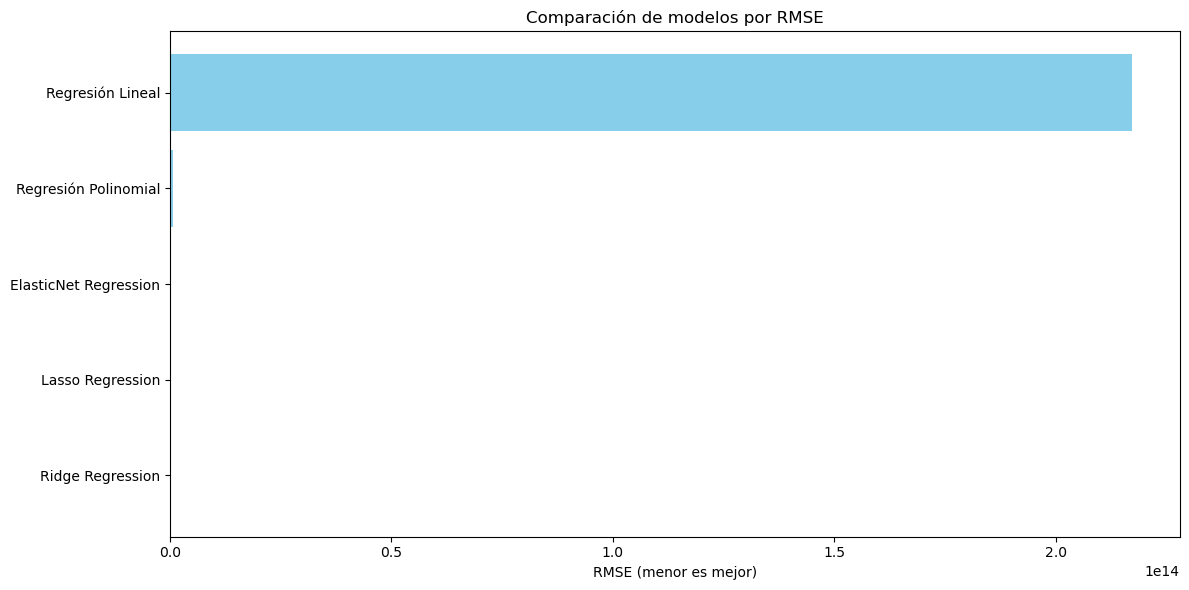

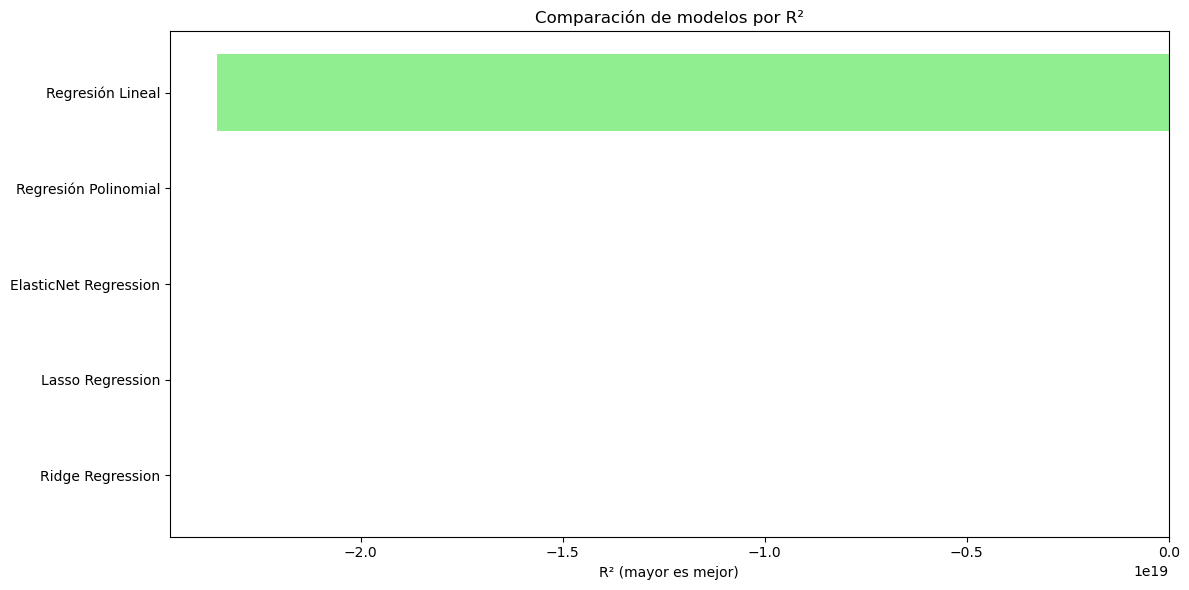


El mejor modelo es: Ridge Regression

Rendimiento del mejor modelo (Ridge Regression) en el conjunto de prueba:
RMSE: 138136.06
MAE: 25884.21
R²: 0.07


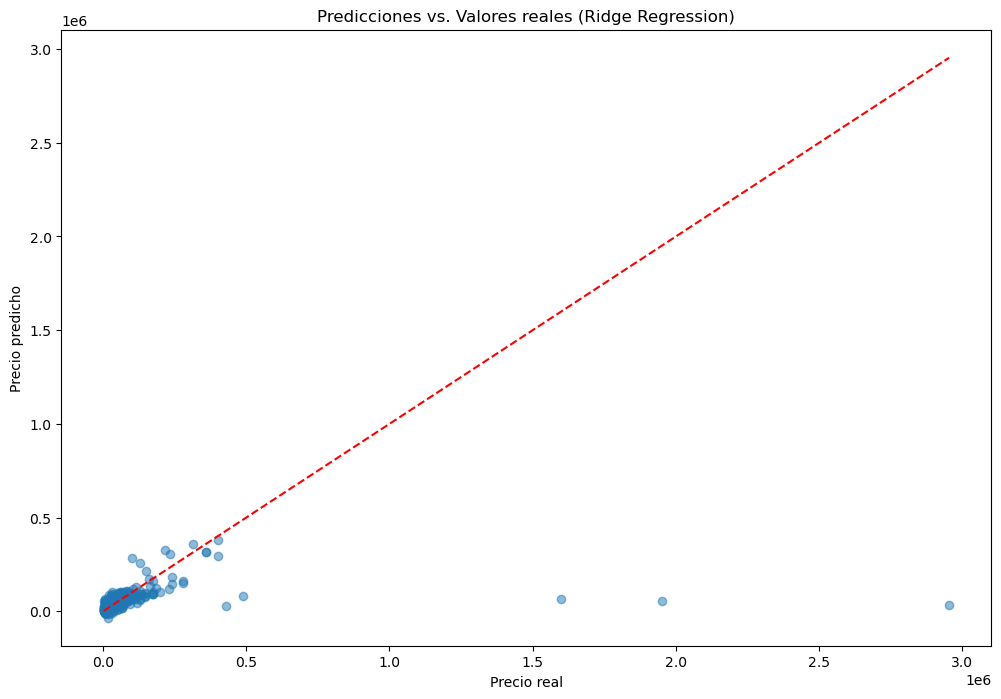

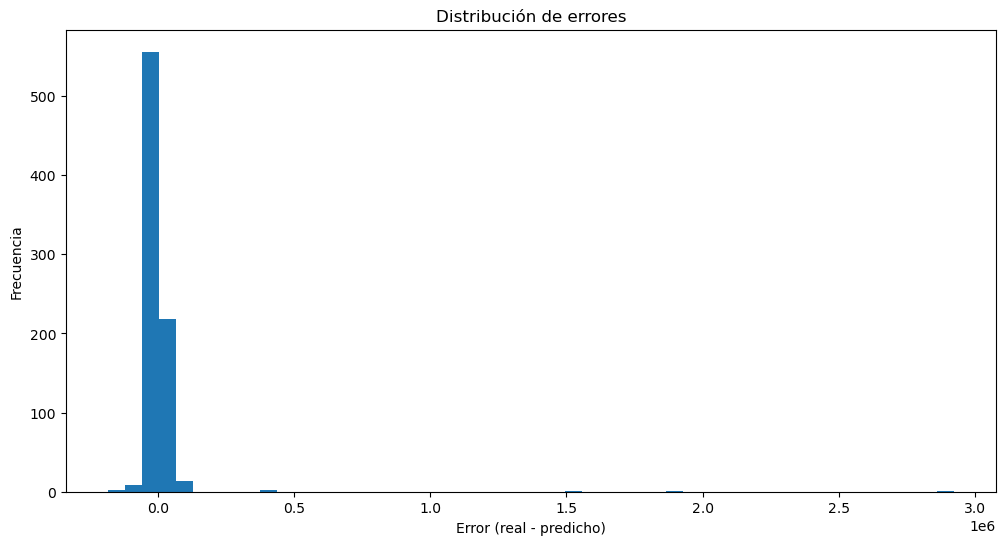

2025-09-14 01:31:45,261 - INFO - Predicción para Toyota Camry 2018: $82742.00
2025-09-14 01:31:45,262 - INFO - Métricas de predicción - RMSE: 35242.00, MAE: 35242.00, R²: -4.94, Vehículos similares: 8
2025-09-14 01:31:45,264 - WARNING - Valor faltante en milage. Usando valor predeterminado: 50000
2025-09-14 01:31:45,266 - WARNING - Valor faltante en engine. Usando valor predeterminado: Standard
2025-09-14 01:31:45,267 - WARNING - Valor faltante en transmission. Usando valor predeterminado: Automatic
2025-09-14 01:31:45,269 - WARNING - Valor faltante en ext_col. Usando valor predeterminado: Standard
2025-09-14 01:31:45,270 - WARNING - Valor faltante en int_col. Usando valor predeterminado: Standard
2025-09-14 01:31:45,272 - WARNING - Valor faltante en accident. Usando valor predeterminado: None reported
2025-09-14 01:31:45,262 - INFO - Métricas de predicción - RMSE: 35242.00, MAE: 35242.00, R²: -4.94, Vehículos similares: 8
2025-09-14 01:31:45,264 - WARNING - Valor faltante en milage. U


Precio predicho para el Toyota Camry 2018: $82742.00

Precio predicho para el Honda Civic 2020 (datos incompletos): $80138.70

=== Guardando modelo ===
Mejor modelo (Ridge Regression) guardado en 'best_model.pkl'
Métricas del modelo guardadas en 'logs/model_metrics.pkl'


In [31]:
# Implementación de diferentes modelos de regresión con scikit-learn

# 1. Regresión Lineal
print("\n=== Regresión Lineal ===")
linear_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

print("Evaluación con validación cruzada:")
rmse_lr, mae_lr, r2_lr = evaluate_model(linear_model, X_train, y_train)
model_results.append(('Regresión Lineal', rmse_lr, mae_lr, r2_lr))

# Entrenamiento final y predicciones
print("\nEntrenamiento y predicciones:")
oof_lr, models_lr = get_oof_predictions(linear_model, X_train, y_train)

# 2. Regresión Polinomial (grado 2)
print("\n=== Regresión Polinomial (grado 2) ===")
poly_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('regressor', LinearRegression())
])

print("Evaluación con validación cruzada:")
rmse_poly, mae_poly, r2_poly = evaluate_model(poly_model, X_train, y_train)
model_results.append(('Regresión Polinomial', rmse_poly, mae_poly, r2_poly))

# 3. Ridge Regression (regularización L2)
print("\n=== Ridge Regression ===")
ridge_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=1.0))
])

print("Evaluación con validación cruzada:")
rmse_ridge, mae_ridge, r2_ridge = evaluate_model(ridge_model, X_train, y_train)
model_results.append(('Ridge Regression', rmse_ridge, mae_ridge, r2_ridge))

# 4. Lasso Regression (regularización L1)
print("\n=== Lasso Regression ===")
lasso_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Lasso(alpha=0.1))
])

print("Evaluación con validación cruzada:")
rmse_lasso, mae_lasso, r2_lasso = evaluate_model(lasso_model, X_train, y_train)
model_results.append(('Lasso Regression', rmse_lasso, mae_lasso, r2_lasso))

# 5. ElasticNet (combinación de L1 y L2)
print("\n=== ElasticNet Regression ===")
elastic_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', ElasticNet(alpha=0.1, l1_ratio=0.5))
])

print("Evaluación con validación cruzada:")
rmse_elastic, mae_elastic, r2_elastic = evaluate_model(elastic_model, X_train, y_train)
model_results.append(('ElasticNet Regression', rmse_elastic, mae_elastic, r2_elastic))

# Comparar modelos
results_df = pd.DataFrame(model_results, columns=['Modelo', 'RMSE', 'MAE', 'R²'])
results_df = results_df.sort_values('RMSE')

print("\n=== Comparación de modelos ===")
print(results_df)

# Visualizar comparación de modelos
plt.figure(figsize=(12, 6))
plt.barh(results_df['Modelo'], results_df['RMSE'], color='skyblue')
plt.xlabel('RMSE (menor es mejor)')
plt.title('Comparación de modelos por RMSE')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.barh(results_df['Modelo'], results_df['R²'], color='lightgreen')
plt.xlabel('R² (mayor es mejor)')
plt.title('Comparación de modelos por R²')
plt.tight_layout()
plt.show()

# Entrenar el mejor modelo en todo el conjunto de entrenamiento
best_model_name = results_df.iloc[0]['Modelo']
print(f"\nEl mejor modelo es: {best_model_name}")

# Crear una instancia del mejor modelo
if best_model_name == 'Regresión Lineal':
    best_model = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', LinearRegression())])
elif best_model_name == 'Regresión Polinomial':
    best_model = Pipeline(steps=[('preprocessor', preprocessor), ('poly', PolynomialFeatures(degree=2, include_bias=False)), ('regressor', LinearRegression())])
elif best_model_name == 'Ridge Regression':
    best_model = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', Ridge(alpha=1.0))])
elif best_model_name == 'Lasso Regression':
    best_model = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', Lasso(alpha=0.1))])
elif best_model_name == 'ElasticNet Regression':
    best_model = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', ElasticNet(alpha=0.1, l1_ratio=0.5))])

# Entrenar el mejor modelo en todo el conjunto de entrenamiento
best_model.fit(X_train, y_train)

# Evaluar en el conjunto de prueba
y_pred = best_model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
mae_test = mean_absolute_error(y_test, y_pred)
r2_test = r2_score(y_test, y_pred)

print(f"\nRendimiento del mejor modelo ({best_model_name}) en el conjunto de prueba:")
print(f"RMSE: {rmse_test:.2f}")
print(f"MAE: {mae_test:.2f}")
print(f"R²: {r2_test:.2f}")

# Visualizar predicciones vs valores reales
plt.figure(figsize=(12, 8))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title(f'Predicciones vs. Valores reales ({best_model_name})')
plt.xlabel('Precio real')
plt.ylabel('Precio predicho')
plt.show()

# Analizar errores
errors = y_test - y_pred
plt.figure(figsize=(12, 6))
plt.hist(errors, bins=50)
plt.title('Distribución de errores')
plt.xlabel('Error (real - predicho)')
plt.ylabel('Frecuencia')
plt.show()

# Configuración de logging
import logging
import os
os.makedirs("logs", exist_ok=True)
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[logging.FileHandler("logs/app.log"), logging.StreamHandler()],
)
logger = logging.getLogger(__name__)

# Función para hacer predicciones con un nuevo vehículo
def predict_price(new_car_data, model):
    """
    Predice el precio de un nuevo vehículo.
    
    Parameters:
    -----------
    new_car_data : dict
        Diccionario con los datos del nuevo vehículo
    model : Pipeline
        Modelo entrenado
    
    Returns:
    --------
    float
        Precio predicho
    """
    # Convertir a DataFrame
    new_car_df = pd.DataFrame([new_car_data])
    
    # Verificar si hay valores faltantes y rellenarlos
    required_cols = ['brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine', 
                     'transmission', 'ext_col', 'int_col', 'accident', 'clean_title']
    
    # Establecer valores predeterminados para campos faltantes
    defaults = {
        'brand': 'missing',
        'model': 'missing',
        'model_year': 2015,  # Valor predeterminado razonable
        'milage': 50000,     # Valor predeterminado razonable
        'fuel_type': 'Gasoline',
        'engine': 'Standard',
        'transmission': 'Automatic',
        'ext_col': 'Standard',
        'int_col': 'Standard',
        'accident': 'None reported',
        'clean_title': 'Yes'
    }
    
    # Rellenar valores faltantes con valores predeterminados
    for col in required_cols:
        if col not in new_car_data or new_car_data[col] is None or pd.isna(new_car_data[col]):
            logger.warning(f"Valor faltante en {col}. Usando valor predeterminado: {defaults[col]}")
            new_car_df[col] = defaults[col]
    
    try:
        # Aplicar las mismas transformaciones que usamos en el entrenamiento
        new_car_df = extract_age_features(new_car_df)
        new_car_df = extract_other_features(new_car_df)
        new_car_df = preprocess_categorical(new_car_df)
        
        # Hacer predicción
        predicted_price = model.predict(new_car_df)[0]
        
        # Calcular similares y métricas
        similares = X_test[(X_test['brand'] == new_car_data.get('brand', defaults['brand'])) &
                           (abs(X_test['model_year'] - new_car_data.get('model_year', defaults['model_year'])) <= 2)]
        
        # Si hay suficientes vehículos similares, calcular métricas
        metrics = {}
        if len(similares) >= 5:
            # Encontrar el valor real más cercano para el cálculo de métricas
            similares_with_price = pd.concat([similares, y_test.loc[similares.index]], axis=1)
            closest_idx = abs(similares_with_price['price'] - predicted_price).idxmin()
            closest_real_price = similares_with_price.loc[closest_idx, 'price']
            
            # Calcular métricas para esta predicción
            prediction_error = abs(predicted_price - closest_real_price)
            prediction_rmse = np.sqrt(prediction_error**2)
            prediction_mae = prediction_error
            
            if closest_real_price != 0:
                prediction_r2 = 1 - (prediction_error**2) / ((closest_real_price - similares_with_price['price'].mean())**2)
            else:
                prediction_r2 = 0
                
            metrics = {
                'prediction_rmse': prediction_rmse,
                'prediction_mae': prediction_mae,
                'prediction_r2': prediction_r2,
                'similar_vehicles_count': len(similares)
            }
            
            # Registrar métricas en el log
            logger.info(f"Predicción para {new_car_data.get('brand', 'N/A')} {new_car_data.get('model', 'N/A')} {new_car_data.get('model_year', 'N/A')}: ${predicted_price:.2f}")
            logger.info(f"Métricas de predicción - RMSE: {prediction_rmse:.2f}, MAE: {prediction_mae:.2f}, R²: {prediction_r2:.2f}, Vehículos similares: {len(similares)}")
        else:
            logger.warning(f"No hay suficientes vehículos similares para calcular métricas precisas. Predicción: ${predicted_price:.2f}")
        
        return predicted_price
        
    except Exception as e:
        logger.error(f"Error en la predicción: {str(e)}")
        # En caso de error, devolver un valor estimado basado en promedios si es posible
        try:
            brand = new_car_data.get('brand', defaults['brand'])
            similar_brand_prices = df[df['brand'] == brand]['price']
            if len(similar_brand_prices) > 0:
                estimated_price = similar_brand_prices.mean()
                logger.warning(f"No se pudo usar el modelo de ML para predicción. Usando solo comparables. Precio estimado: ${estimated_price:.2f}")
                return estimated_price
            else:
                logger.warning("No se encontraron vehículos comparables. Usando el precio promedio general.")
                return df['price'].mean()
        except:
            logger.error("Error al calcular precios comparables. Devolviendo valor predeterminado.")
            return 25000.0  # Valor predeterminado razonable

# Ejemplo de uso
nuevo_carro = {
    'brand': 'Toyota',
    'model': 'Camry',
    'model_year': 2018,
    'milage': 50000,
    'fuel_type': 'Gasoline',
    'engine': '2.5L 4 Cylinder',
    'transmission': 'Automatic',
    'ext_col': 'White',
    'int_col': 'Black',
    'accident': 'None reported',
    'clean_title': 'Yes'
}

# Predecir precio para el nuevo carro
predicted_price = predict_price(nuevo_carro, best_model)
print(f"\nPrecio predicho para el Toyota Camry 2018: ${predicted_price:.2f}")

# Ejemplo con datos incompletos para probar el manejo de valores faltantes
nuevo_carro_incompleto = {
    'brand': 'Honda',
    'model': 'Civic',
    'model_year': 2020,
    # Falta el millaje
    'fuel_type': 'Gasoline',
    # Faltan otros valores
}

# Predecir precio con datos incompletos
predicted_price_incompleto = predict_price(nuevo_carro_incompleto, best_model)
print(f"\nPrecio predicho para el Honda Civic 2020 (datos incompletos): ${predicted_price_incompleto:.2f}")

# Guardar el mejor modelo junto con sus métricas
import joblib

# Crear directorio para guardar los modelos si no existe
import os
if not os.path.exists('logs'):
    os.makedirs('logs')

# Guardar métricas del modelo en el archivo de log
logger.info(f"=== Métricas del mejor modelo ({best_model_name}) ===")
logger.info(f"RMSE: {rmse_test:.2f}")
logger.info(f"MAE: {mae_test:.2f}")
logger.info(f"R²: {r2_test:.2f}")

# Guardar el modelo
print("\n=== Guardando modelo ===")
joblib.dump(best_model, 'best_model.pkl')
print(f"Mejor modelo ({best_model_name}) guardado en 'best_model.pkl'")

# También guardar las métricas del modelo para referencia futura
model_metrics = {
    'name': best_model_name,
    'rmse': rmse_test,
    'mae': mae_test,
    'r2': r2_test
}
joblib.dump(model_metrics, 'logs/model_metrics.pkl')
print(f"Métricas del modelo guardadas en 'logs/model_metrics.pkl'")


=== Análisis de coeficientes del modelo ===
Top 10 coeficientes positivos:
         Feature    Coefficient
52    Feature_52  212665.034008
31    Feature_31  153731.639684
19    Feature_19  100417.933972
169  Feature_169   53351.593161
197  Feature_197   48671.143676
41    Feature_41   46949.592782
153  Feature_153   46562.601703
141  Feature_141   40053.116549
6      Feature_6   37436.161252
138  Feature_138   25608.836065

Top 10 coeficientes negativos:
         Feature   Coefficient
121  Feature_121 -22062.896593
97    Feature_97 -28417.863191
49    Feature_49 -31016.767137
42    Feature_42 -50529.210451
32    Feature_32 -59161.904333
38    Feature_38 -60280.022222
27    Feature_27 -66707.182260
10    Feature_10 -68521.716135
11    Feature_11 -69063.815909
33    Feature_33 -71192.315285


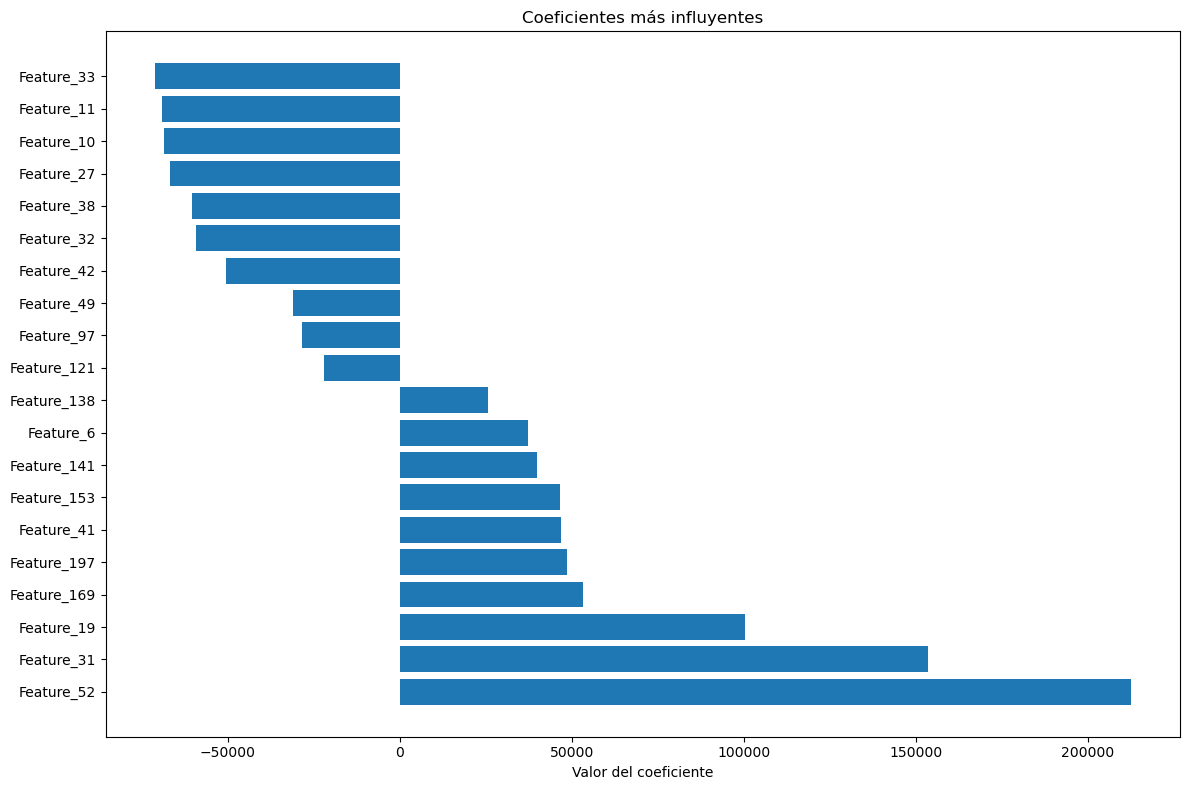


=== Relación entre características principales y precio ===


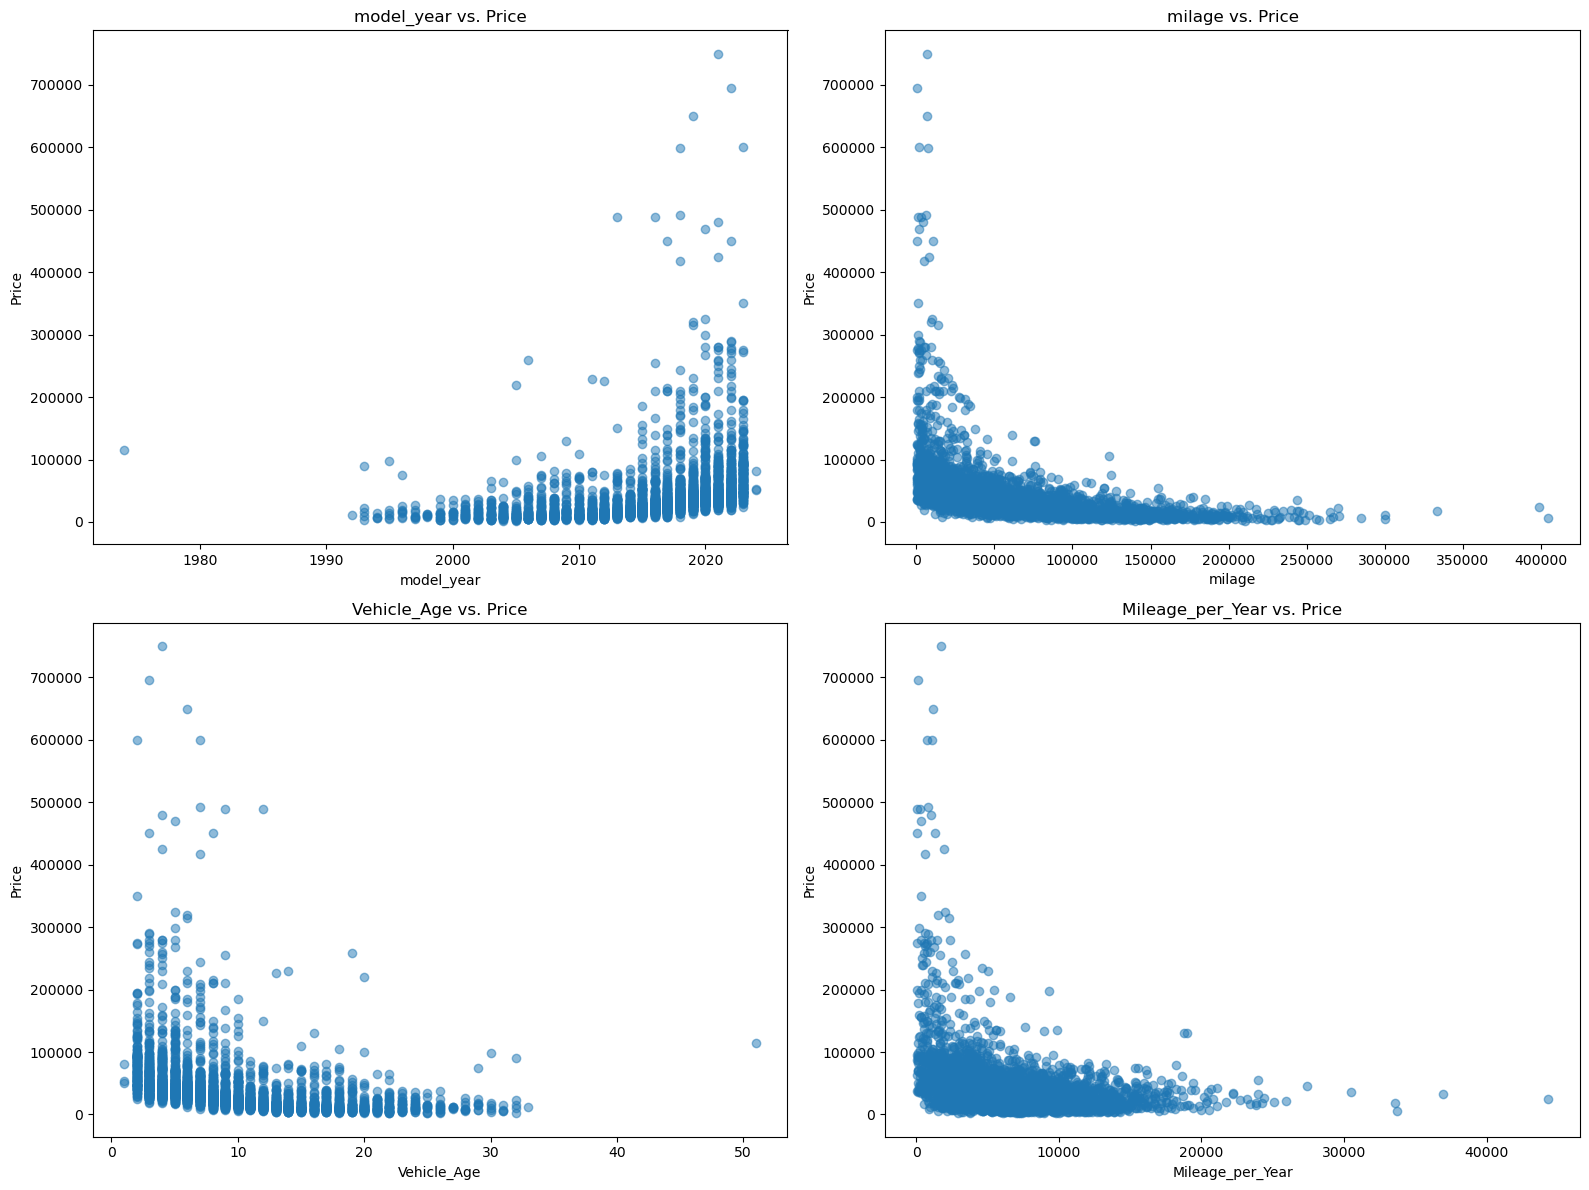


=== Análisis de errores por segmento de precio ===
Error por segmento de precio:
                       Error                     Abs_Error                 \
                        mean            std           mean            std   
Price_Segment                                                               
<10K            -4270.226644   15211.036792   10886.885942   11404.046584   
10K-20K         -5209.135693   13847.968792   10531.785104   10364.387688   
20K-30K        -11070.885892   18138.501135   16240.788570   13668.429974   
30K-50K        -10633.767187   16875.157145   16367.234611   11370.249603   
50K-100K          654.400514   25883.743914   17567.331928   18958.711630   
>100K          182622.456742  533991.544741  201886.575053  526860.647411   

              Relative_Error                  
                        mean       std count  
Price_Segment                                 
<10K                1.655075  1.843877    98  
10K-20K             0.664496  0.6174

C:\Users\User\AppData\Local\Temp\ipykernel_21824\1847135102.py:76: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segment_error = y_test_df.groupby('Price_Segment').agg({


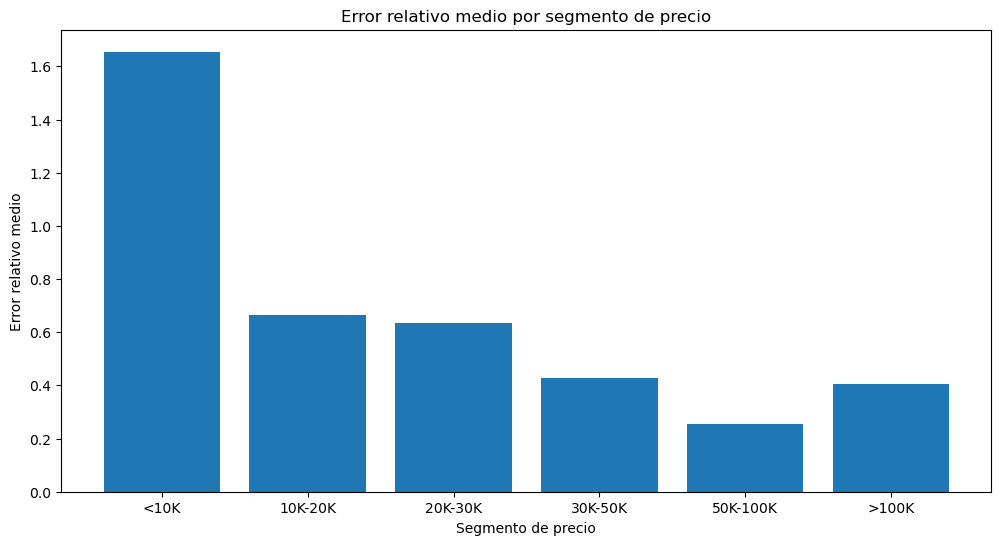

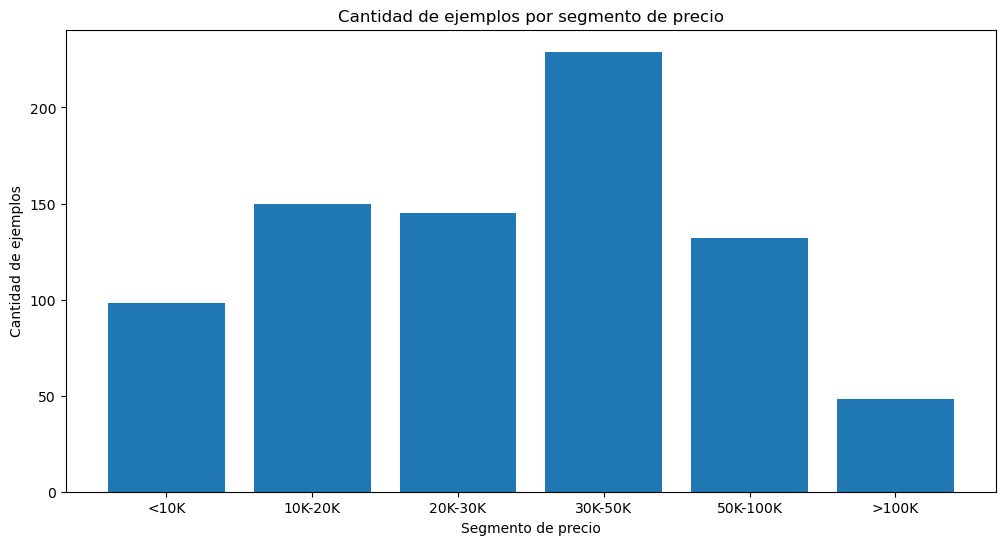


=== Análisis por marca de carro ===
Marcas con menor error absoluto:
            Real_Price              Error                  Abs_Error  \
                  mean count         mean           std         mean   
Brand                                                                  
FIAT      11500.000000     1 -1714.122461           NaN  1714.122461   
Saab       7500.000000     1 -2227.838922           NaN  2227.838922   
Genesis   54543.000000     1  3020.503533           NaN  3020.503533   
Pontiac   14283.333333     3 -3119.807563   6344.935601  3864.472001   
Mercury   13600.000000     2 -1899.540556   5918.821229  4185.238627   
Rivian    96000.000000     2  1344.375942   8244.814044  5829.963920   
Chrysler  18986.250000     4  3808.626507   7865.290450  6406.774108   
Lincoln   31756.800000    10  4125.965711   8849.647134  6582.128185   
Volvo     23074.750000     8 -1417.206647  10579.264399  7606.220689   
Buick     15433.555556     9 -8233.752877   8626.606999  8948.5887

C:\Users\User\AppData\Local\Temp\ipykernel_21824\1847135102.py:115: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  brand_error = test_results.groupby('Brand').agg({
C:\Users\User\AppData\Local\Temp\ipykernel_21824\1847135102.py:134: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  brand_mae = top_brands_df.groupby('Brand')['Abs_Error'].mean().sort_values()


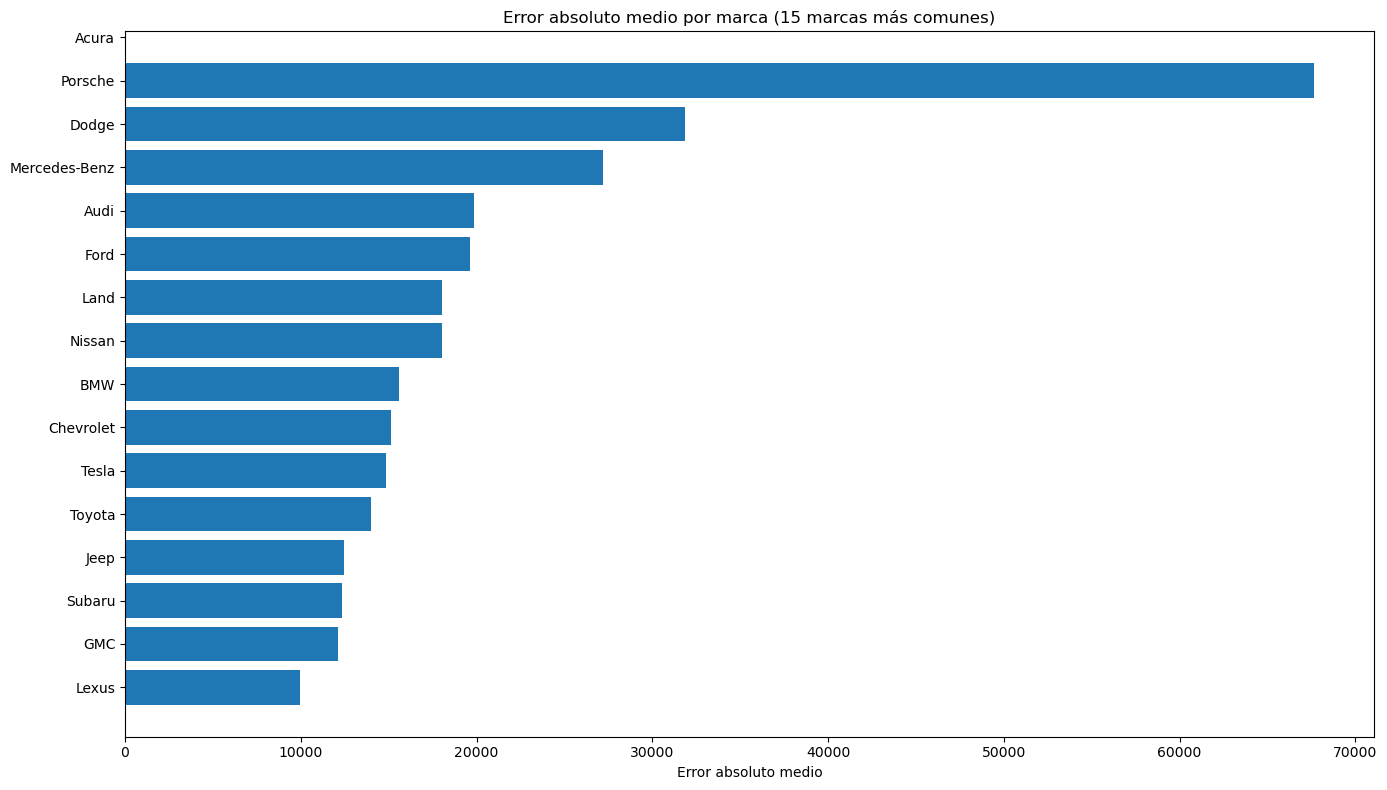


=== Curva de aprendizaje ===


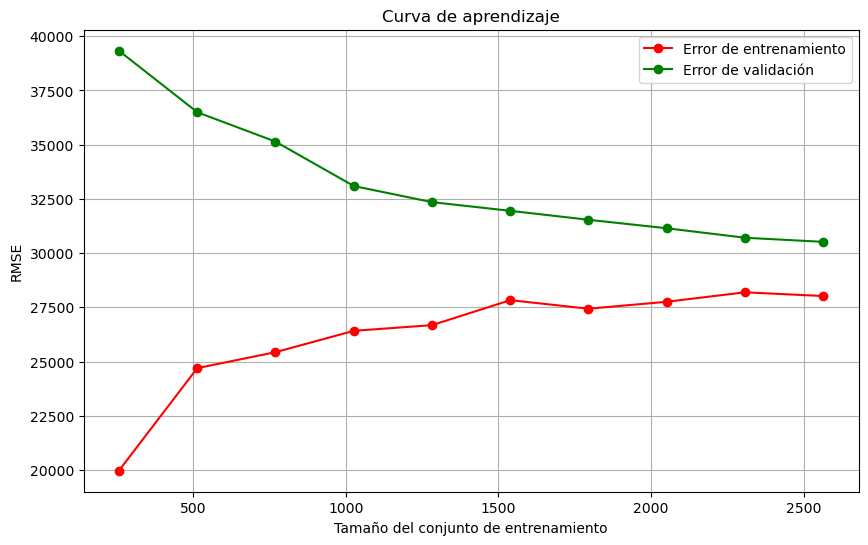


=== Comparación entre modelos de regresión lineal y regularización ===
El impacto de la regularización se puede observar comparando los resultados de:
- Regresión Lineal: RMSE=217164570405316.81, R²=-23543143968772202496.00
- Ridge (L2): RMSE=30383.48, R²=0.64
- Lasso (L1): RMSE=30552.07, R²=0.63
- ElasticNet (L1+L2): RMSE=38872.35, R²=0.42


In [ ]:
# Análisis adicional de los resultados y el modelo

# 1. Análisis de sensibilidad para regresión lineal y polinomial
if best_model_name in ['Regresión Lineal', 'Regresión Polinomial', 'Ridge Regression', 'Lasso Regression', 'ElasticNet Regression']:
    
    print("\n=== Análisis de coeficientes del modelo ===")
    
    # Para regresión lineal, podemos acceder a los coeficientes
    if hasattr(best_model.named_steps['regressor'], 'coef_'):
        # Obtener nombres de características después del preprocesamiento
        if best_model_name == 'Regresión Polinomial':
            # Para polinomial tenemos que transformar primero
            transformed_data = best_model.named_steps['preprocessor'].transform(X_train)
            transformed_data = best_model.named_steps['poly'].transform(transformed_data)
            feature_names = [f'Feature_{i}' for i in range(transformed_data.shape[1])]
        else:
            transformed_data = best_model.named_steps['preprocessor'].transform(X_train)
            feature_names = [f'Feature_{i}' for i in range(transformed_data.shape[1])]
        
        # Obtener coeficientes
        coefficients = best_model.named_steps['regressor'].coef_
        
        # Crear DataFrame para visualizar los coeficientes
        coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
        coef_df = coef_df.sort_values('Coefficient', ascending=False)
        
        # Mostrar los coeficientes más importantes
        print("Top 10 coeficientes positivos:")
        print(coef_df.head(10))
        
        print("\nTop 10 coeficientes negativos:")
        print(coef_df.tail(10))
        
        # Visualizar los coeficientes más importantes
        plt.figure(figsize=(12, 8))
        top_coef = pd.concat([coef_df.head(10), coef_df.tail(10)])
        plt.barh(top_coef['Feature'], top_coef['Coefficient'])
        plt.title('Coeficientes más influyentes')
        plt.xlabel('Valor del coeficiente')
        plt.tight_layout()
        plt.show()

# 3. Análisis de la relación entre características y precio
print("\n=== Relación entre características principales y precio ===")

# Seleccionar algunas características numéricas para análisis
numeric_features = ['model_year', 'milage', 'Vehicle_Age', 'Mileage_per_Year']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, feature in enumerate(numeric_features):
    axes[i].scatter(X_train[feature], y_train, alpha=0.5)
    axes[i].set_title(f'{feature} vs. Price')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Price')

plt.tight_layout()
plt.show()

# 4. Análisis de errores por segmento de precio
print("\n=== Análisis de errores por segmento de precio ===")

# Crear segmentos de precio
price_bins = [0, 10000, 20000, 30000, 50000, 100000, float('inf')]
price_labels = ['<10K', '10K-20K', '20K-30K', '30K-50K', '50K-100K', '>100K']

# Asignar segmentos a los precios reales
y_test_df = pd.DataFrame({'Price': y_test, 'Predicted': y_pred})
y_test_df['Price_Segment'] = pd.cut(y_test_df['Price'], bins=price_bins, labels=price_labels)
y_test_df['Error'] = y_test_df['Price'] - y_test_df['Predicted']
y_test_df['Abs_Error'] = np.abs(y_test_df['Error'])
y_test_df['Relative_Error'] = y_test_df['Abs_Error'] / y_test_df['Price']

# Calcular error por segmento
segment_error = y_test_df.groupby('Price_Segment').agg({
    'Error': ['mean', 'std'],
    'Abs_Error': ['mean', 'std'],
    'Relative_Error': ['mean', 'std', 'count']
})

print("Error por segmento de precio:")
print(segment_error)

# Visualizar error relativo por segmento
plt.figure(figsize=(12, 6))
plt.bar(segment_error.index, segment_error[('Relative_Error', 'mean')])
plt.title('Error relativo medio por segmento de precio')
plt.xlabel('Segmento de precio')
plt.ylabel('Error relativo medio')
plt.show()

# Visualizar cantidad de ejemplos por segmento
plt.figure(figsize=(12, 6))
plt.bar(segment_error.index, segment_error[('Relative_Error', 'count')])
plt.title('Cantidad de ejemplos por segmento de precio')
plt.xlabel('Segmento de precio')
plt.ylabel('Cantidad de ejemplos')
plt.show()

# 5. Análisis por marca de carro
print("\n=== Análisis por marca de carro ===")

# Crear un DataFrame con los resultados del test
test_results = pd.DataFrame({
    'Brand': X_test['brand'],
    'Real_Price': y_test,
    'Predicted_Price': y_pred,
    'Error': y_test - y_pred,
    'Abs_Error': np.abs(y_test - y_pred),
    'Relative_Error': np.abs(y_test - y_pred) / y_test
})

# Calcular error por marca
brand_error = test_results.groupby('Brand').agg({
    'Real_Price': ['mean', 'count'],
    'Error': ['mean', 'std'],
    'Abs_Error': ['mean', 'std'],
    'Relative_Error': ['mean', 'std']
}).sort_values(('Abs_Error', 'mean'), ascending=True)

# Mostrar las 10 marcas con menor y mayor error
print("Marcas con menor error absoluto:")
print(brand_error.head(10))

print("\nMarcas con mayor error absoluto:")
print(brand_error.tail(10))

# Visualizar error medio absoluto por marca (para las 15 marcas más comunes)
top_brands = test_results['Brand'].value_counts().nlargest(15).index
top_brands_df = test_results[test_results['Brand'].isin(top_brands)]

plt.figure(figsize=(14, 8))
brand_mae = top_brands_df.groupby('Brand')['Abs_Error'].mean().sort_values()
plt.barh(brand_mae.index, brand_mae.values)
plt.title('Error absoluto medio por marca (15 marcas más comunes)')
plt.xlabel('Error absoluto medio')
plt.tight_layout()
plt.show()

# 6. Curva de aprendizaje para el mejor modelo
from sklearn.model_selection import learning_curve

print("\n=== Curva de aprendizaje ===")

# Definir tamaños de conjuntos de entrenamiento
train_sizes = np.linspace(0.1, 1.0, 10)

# Calcular curva de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train, y_train, 
    train_sizes=train_sizes, cv=5,
    scoring='neg_mean_squared_error')

# Convertir a RMSE
train_rmse = np.sqrt(-train_scores.mean(axis=1))
test_rmse = np.sqrt(-test_scores.mean(axis=1))

# Visualizar curva de aprendizaje
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_rmse, 'o-', color='r', label='Error de entrenamiento')
plt.plot(train_sizes, test_rmse, 'o-', color='g', label='Error de validación')
plt.title('Curva de aprendizaje')
plt.xlabel('Tamaño del conjunto de entrenamiento')
plt.ylabel('RMSE')
plt.legend(loc='best')
plt.grid()
plt.show()


